In [1]:
import quantumpropagator as qp
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact,fixed #, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import sys
import glob
import pandas as pd
import numpy as np

from scipy import fftpack
%load_ext Cython
%matplotlib ipympl

#plt.rcParams.update({'font.size': 10})

In [2]:
fol = '/home/alessio/w-August-Run/'
outputFolder = '/home/alessio/w-August-Run/OUTPUTS'
subfolders2 = sorted([dir for dir in os.listdir(fol) if os.path.isdir(os.path.join(fol,dir))])
subfolders =  [ dir for dir in subfolders2 if dir not in ['HTML','csv','OUTPUTS','FRANCOISE'] ]
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> b-UV-0.22_0000
1 -> m-IR-Polarized-INV_0000
2 -> m-IR-Polarized-LON_0000
3 -> m-IR-Polarized-NOR_0000
4 -> position-from1_0000
5 -> position-from2_0000
6 -> position-from3_0000
7 -> position-from4_0000
8 -> position-from5_0000
9 -> position-from6_0000
10 -> t-FC_excited_phi_0000
11 -> t-IR-to-excite-phi_0000
12 -> t-UV-0.22_excited_phi_0001
13 -> w-SubMask_from_IR_time_reversed_0000
14 -> x-SubMask_from_IR_0000
15 -> x-SubMask_from_IR_INV_0000
16 -> z-from1_0000



In [3]:
%%cython
# -a
import numpy as np
import quantumpropagator as qp
from cmath import exp,pi

cdef extern from "complex.h":
        double complex cexp(double complex)

# from libc.math cimport exp

# cdef extern from "<complex.h>" namespace "std":
#     double complex exp(double complex z)
#     float complex exp(float complex z)  # overload

def fft_artisanal2(x):
    N = len(x)
    if N <= 1: return x
    even = fft_artisanal(x[0::2])
    odd =  fft_artisanal(x[1::2])
    T = [ exp(-2j*pi*k/N)*odd[k] for k in range(N//2) ]
    return [even[k] + T[k] for k in range(N//2)] + [even[k] - T[k] for k in range(N//2)]

def fft_artisanal(time,signal):
    dt = time[1] - time[0]
    nstep = time.size
    all_time = nstep * dt
    sx = -np.pi/dt
    dx = np.pi/dt
    dw = (2 * np.pi)/all_time
    freq = np.arange(0,dx,dw)
    freq_size = freq.size
    fft_array, freq = fft_c(time, signal, freq, dt, freq_size, nstep)
    return (fft_array, np.array(freq))

cdef fft_c(double [:] time, double [:] signal, double [:] freq, int dt, int freq_size, int nstep):
    cdef:
        int k,j
        double complex I = -1j
        
    fft_array = np.zeros(freq_size, dtype=complex)
    
    for k in range(freq_size):
        for j in range(nstep):

            fft_array[k] = fft_array[k] + cexp(I * freq[k] * time[j]) * signal[j]

    return(fft_array, freq)

In [4]:
# define all labels
nstates = 8
permanents = []
transitions = []

for lab1 in ['x','y','z']:
    for lab2 in range(nstates):
        permanents.append('perm_{}_{}'.format(lab1,lab2))
        for lab3 in range(lab2+1,nstates):
            transitions.append('trans_{}_{}_{}'.format(lab1,lab2,lab3))
            

print(permanents + transitions)

['perm_x_0', 'perm_x_1', 'perm_x_2', 'perm_x_3', 'perm_x_4', 'perm_x_5', 'perm_x_6', 'perm_x_7', 'perm_y_0', 'perm_y_1', 'perm_y_2', 'perm_y_3', 'perm_y_4', 'perm_y_5', 'perm_y_6', 'perm_y_7', 'perm_z_0', 'perm_z_1', 'perm_z_2', 'perm_z_3', 'perm_z_4', 'perm_z_5', 'perm_z_6', 'perm_z_7', 'trans_x_0_1', 'trans_x_0_2', 'trans_x_0_3', 'trans_x_0_4', 'trans_x_0_5', 'trans_x_0_6', 'trans_x_0_7', 'trans_x_1_2', 'trans_x_1_3', 'trans_x_1_4', 'trans_x_1_5', 'trans_x_1_6', 'trans_x_1_7', 'trans_x_2_3', 'trans_x_2_4', 'trans_x_2_5', 'trans_x_2_6', 'trans_x_2_7', 'trans_x_3_4', 'trans_x_3_5', 'trans_x_3_6', 'trans_x_3_7', 'trans_x_4_5', 'trans_x_4_6', 'trans_x_4_7', 'trans_x_5_6', 'trans_x_5_7', 'trans_x_6_7', 'trans_y_0_1', 'trans_y_0_2', 'trans_y_0_3', 'trans_y_0_4', 'trans_y_0_5', 'trans_y_0_6', 'trans_y_0_7', 'trans_y_1_2', 'trans_y_1_3', 'trans_y_1_4', 'trans_y_1_5', 'trans_y_1_6', 'trans_y_1_7', 'trans_y_2_3', 'trans_y_2_4', 'trans_y_2_5', 'trans_y_2_6', 'trans_y_2_7', 'trans_y_3_4', 'trans

['trans_x_0_1', 'trans_x_1_2', 'trans_x_1_3', 'trans_x_1_4']
['trans_y_0_1', 'trans_y_1_2', 'trans_y_1_3', 'trans_y_1_4', 'trans_y_1_5', 'trans_y_2_3', 'trans_y_6_7']
['perm_z_0', 'perm_z_1', 'trans_z_0_1', 'trans_z_1_4']
['perm_x_1', 'trans_x_0_1', 'trans_x_1_2', 'trans_x_1_3', 'trans_x_1_4', 'trans_x_1_5', 'trans_x_2_4', 'trans_x_2_5']
['trans_y_0_1', 'trans_y_1_2', 'trans_y_1_3', 'trans_y_1_4', 'trans_y_1_5', 'trans_y_2_3', 'trans_y_2_4']
['perm_z_1', 'perm_z_2', 'trans_z_0_1']
['trans_x_0_1', 'trans_x_1_2', 'trans_x_1_3', 'trans_x_2_4', 'trans_x_3_7']
['trans_y_0_1', 'trans_y_1_2', 'trans_y_1_3', 'trans_y_1_6', 'trans_y_2_3', 'trans_y_2_7']
['perm_z_0', 'perm_z_1', 'perm_z_2', 'perm_z_3', 'trans_z_0_1', 'trans_z_0_2', 'trans_z_1_4']
['trans_x_0_1', 'trans_x_1_2', 'trans_x_1_3', 'trans_x_1_4', 'trans_x_2_3', 'trans_x_2_4', 'trans_x_2_5', 'trans_x_2_6']
['trans_y_0_1', 'trans_y_1_2', 'trans_y_1_3', 'trans_y_2_3', 'trans_y_2_4', 'trans_y_2_6']
['perm_z_1', 'perm_z_2', 'perm_z_3', 'tra

/home/alessio/config/quantumpropagator/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


['perm_z_0', 'perm_z_1', 'perm_z_2', 'perm_z_3', 'trans_z_0_1', 'trans_z_0_2']
['trans_x_0_1', 'trans_x_1_2', 'trans_x_1_3', 'trans_x_2_3', 'trans_x_2_4', 'trans_x_2_5', 'trans_x_2_6', 'trans_x_3_7']
['trans_y_0_1', 'trans_y_1_2', 'trans_y_1_3', 'trans_y_2_3', 'trans_y_2_6']
['perm_z_1', 'perm_z_2', 'perm_z_3', 'trans_z_0_1']
['perm_x_1', 'trans_x_0_1', 'trans_x_1_2', 'trans_x_1_3', 'trans_x_1_4', 'trans_x_1_5', 'trans_x_2_4']
['trans_y_0_1', 'trans_y_1_2', 'trans_y_1_3']
['perm_z_1', 'trans_z_0_1']
['perm_x_1', 'trans_x_0_1', 'trans_x_1_2', 'trans_x_1_3', 'trans_x_1_4', 'trans_x_1_5', 'trans_x_2_4']
['trans_y_0_1', 'trans_y_1_2', 'trans_y_2_3']
['perm_z_1', 'trans_z_0_1']


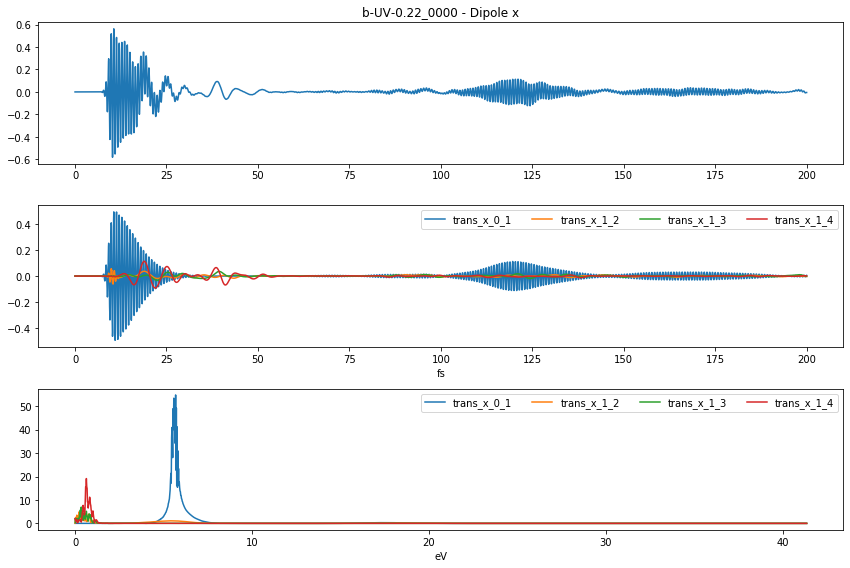

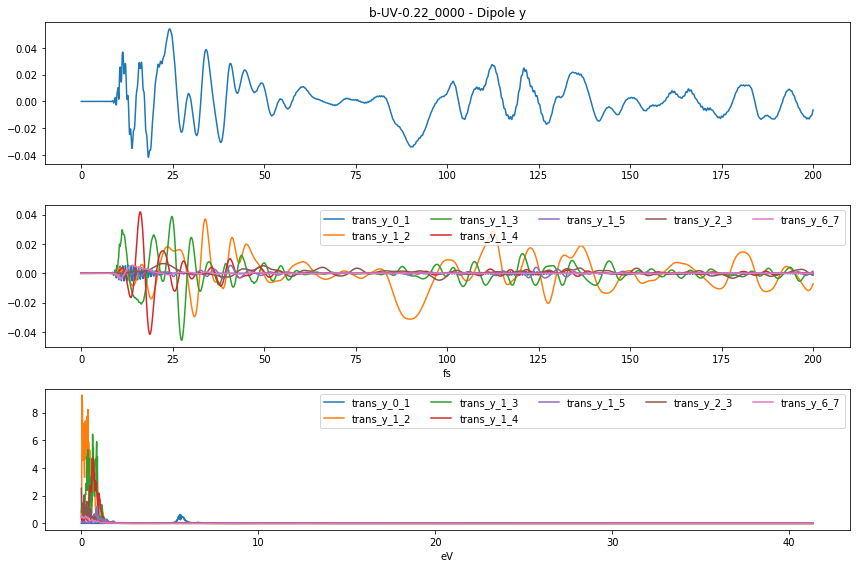

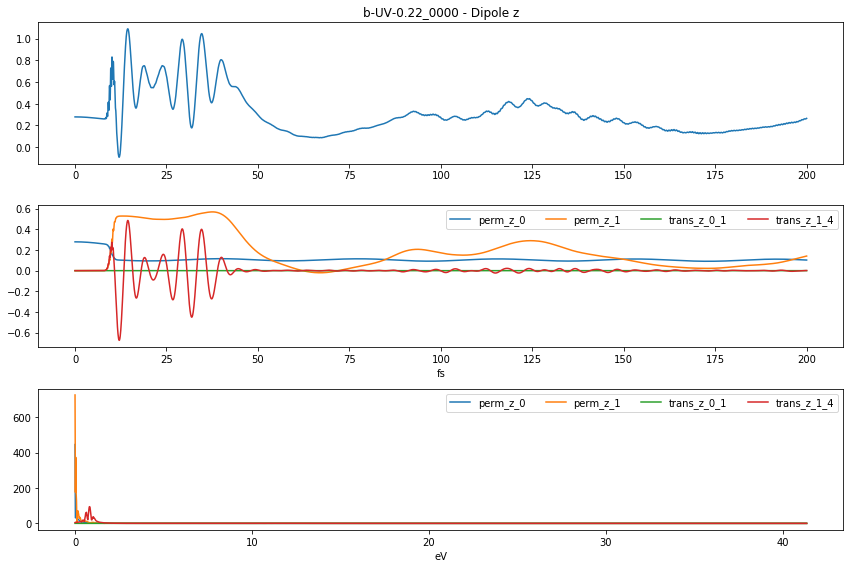

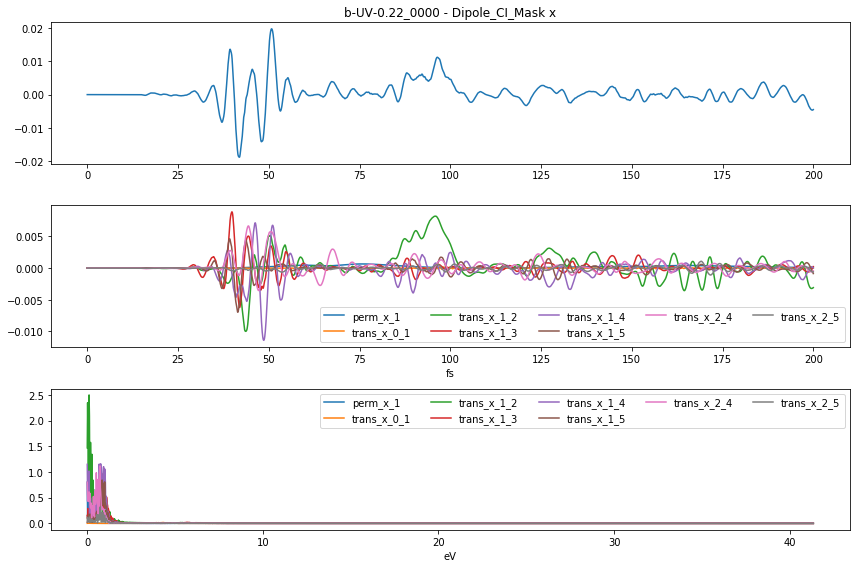

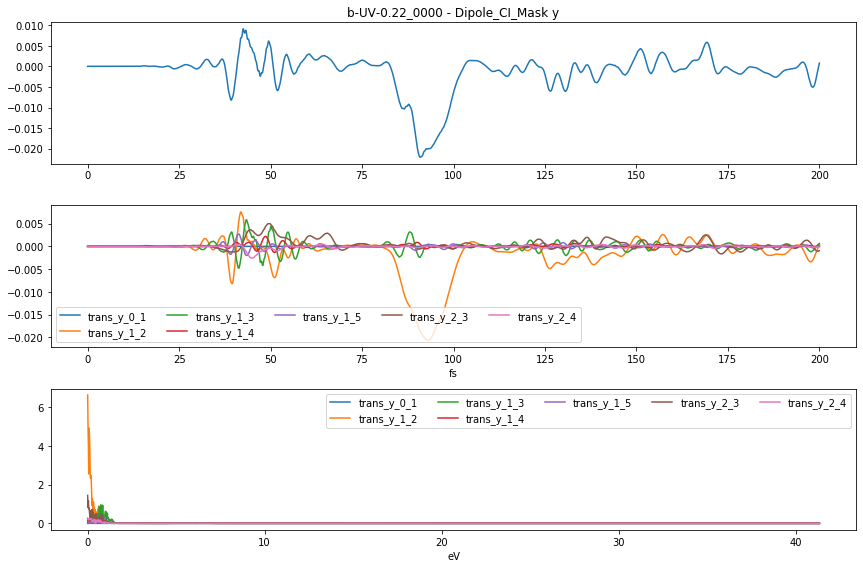

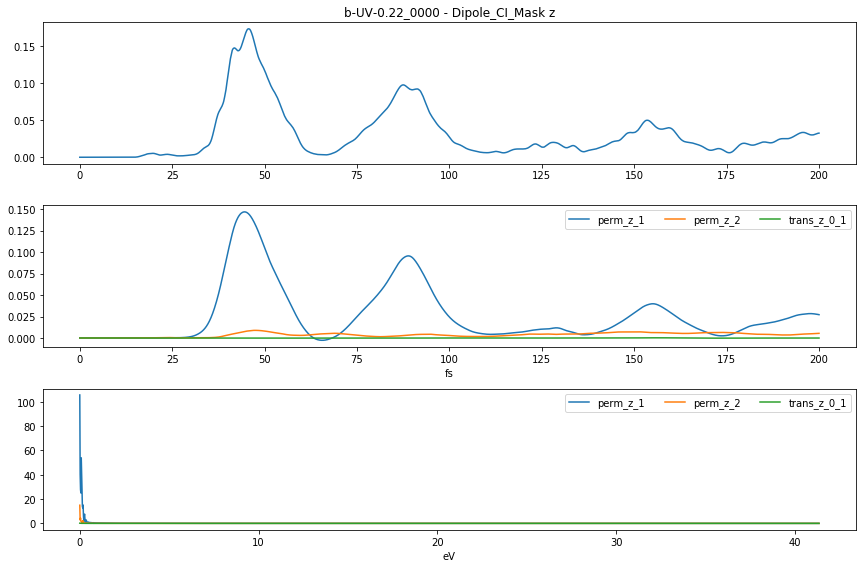

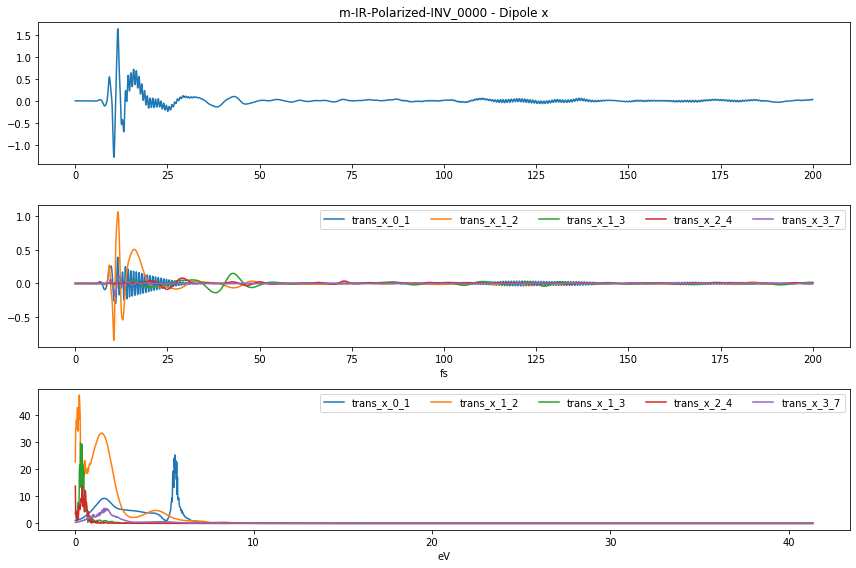

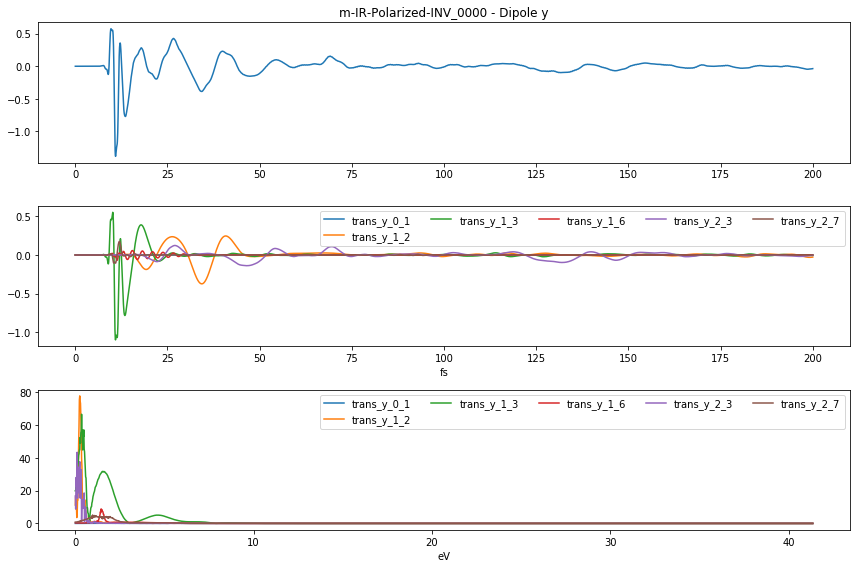

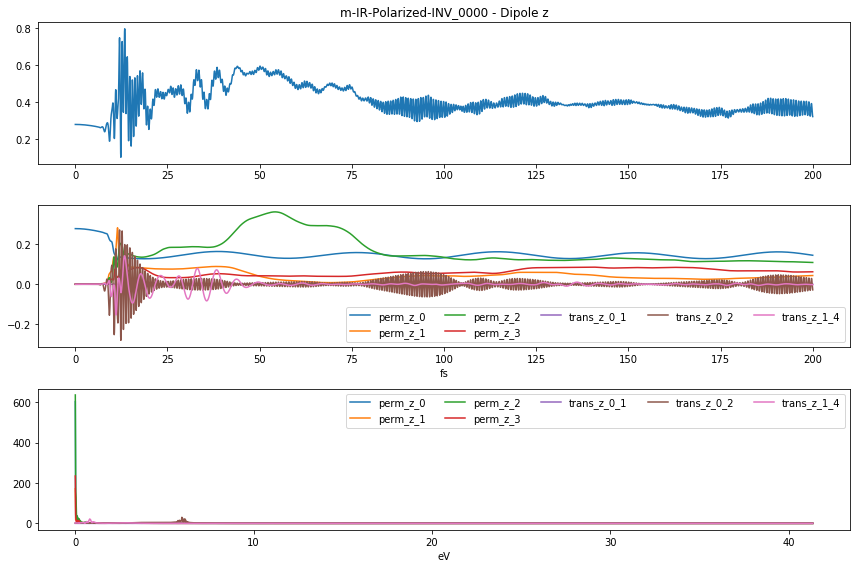

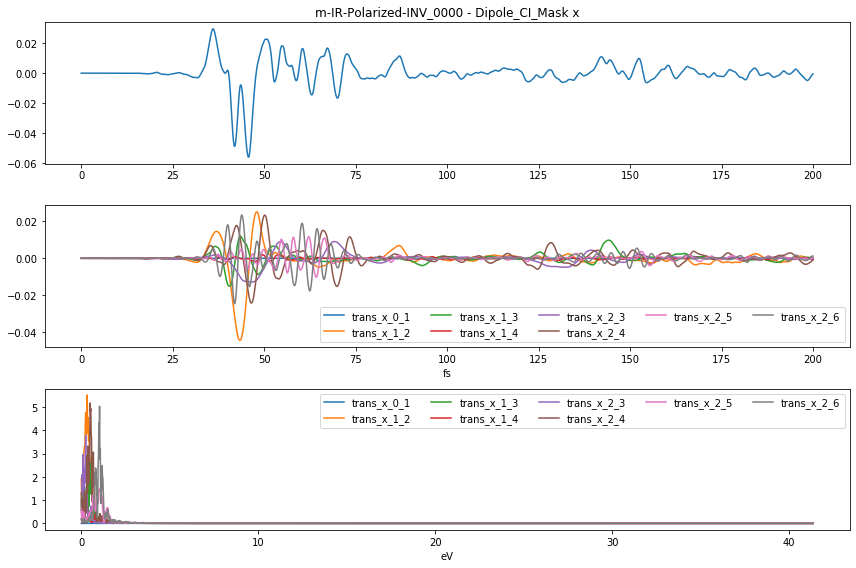

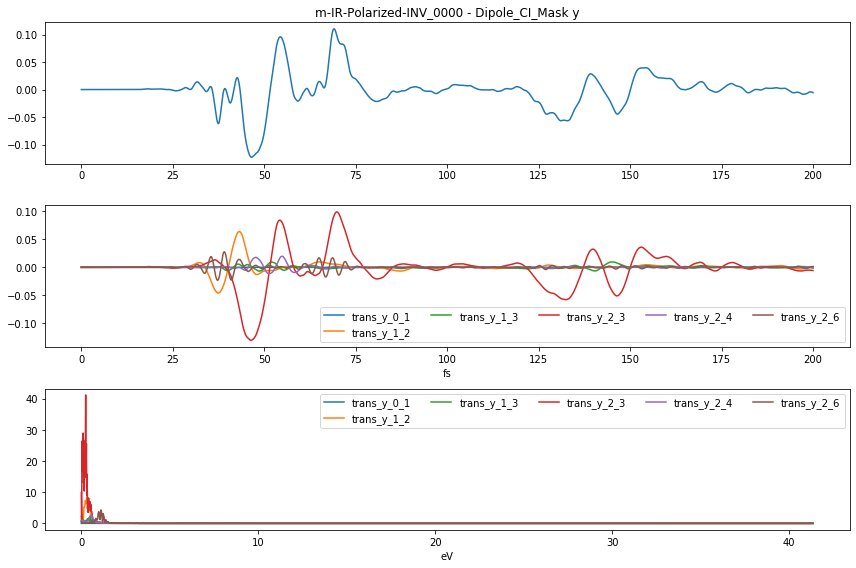

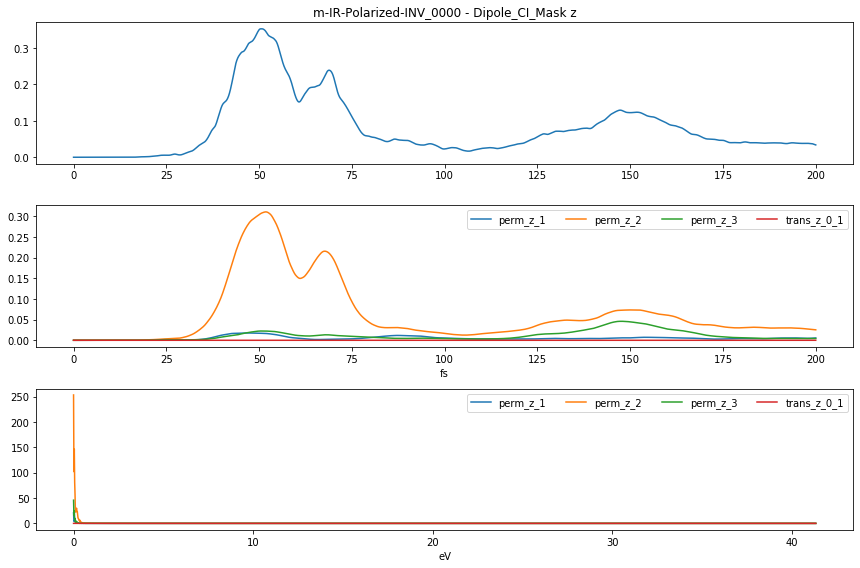

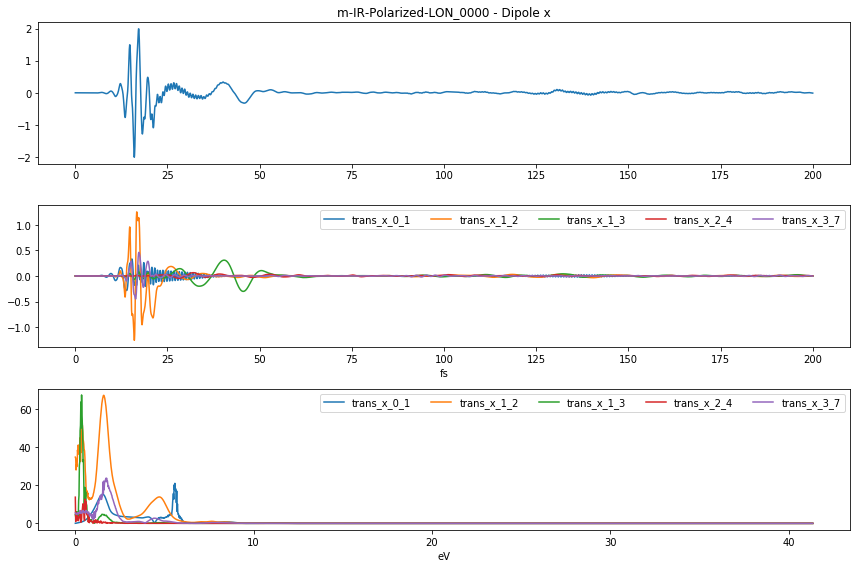

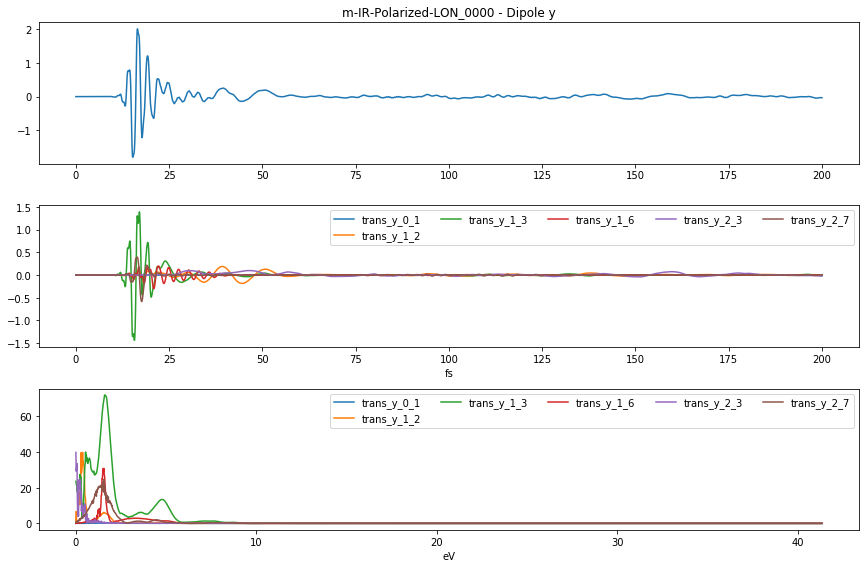

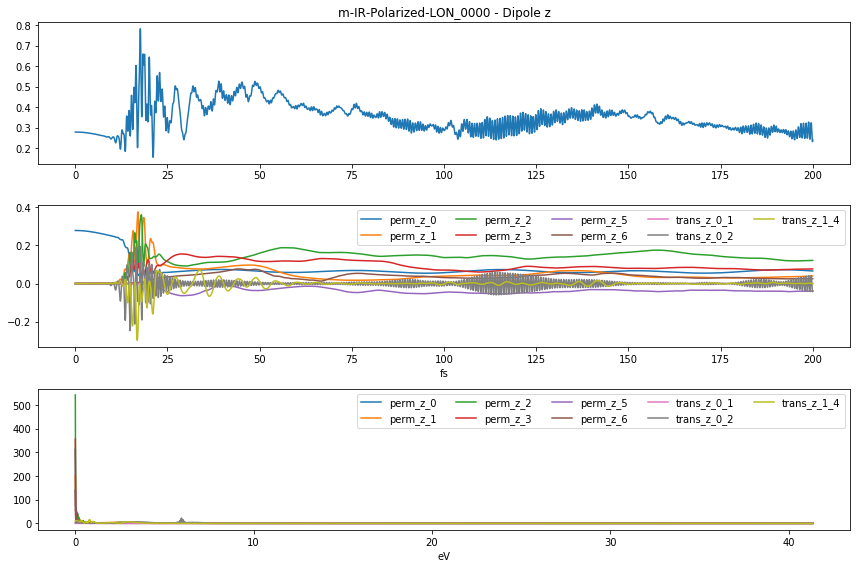

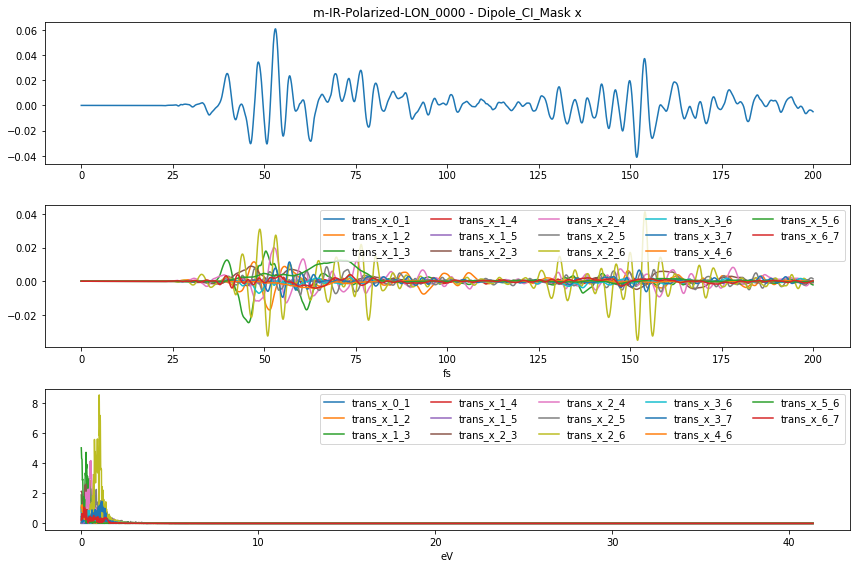

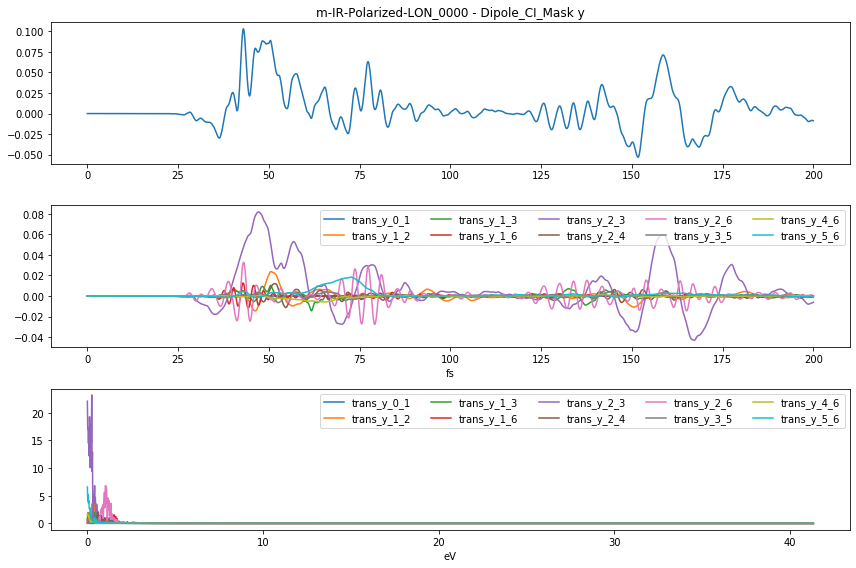

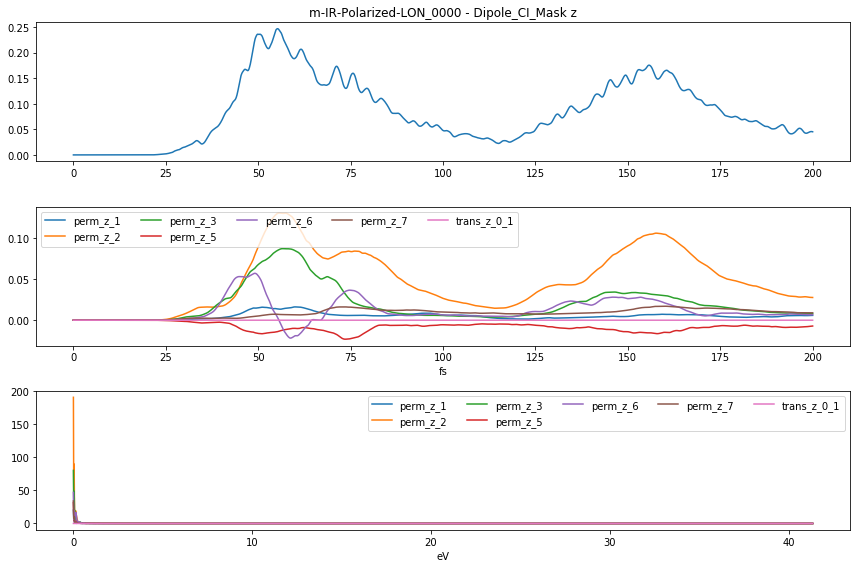

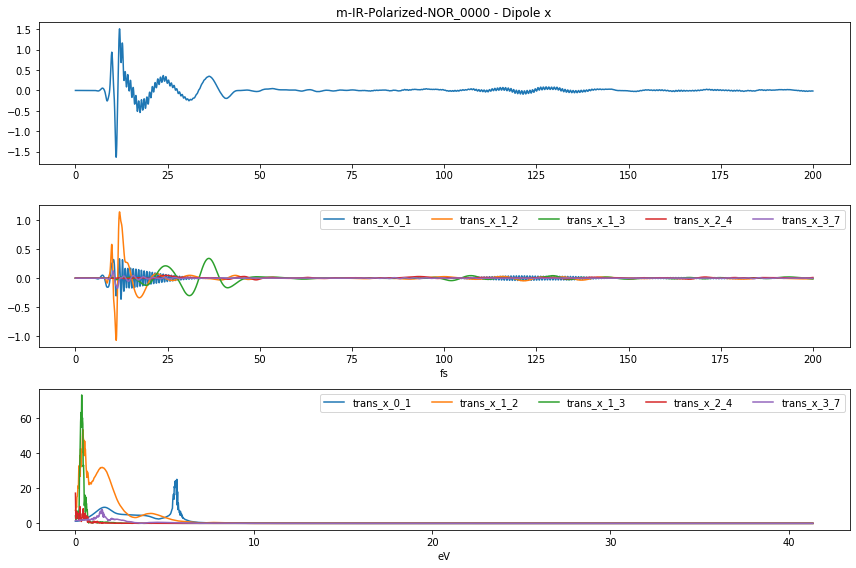

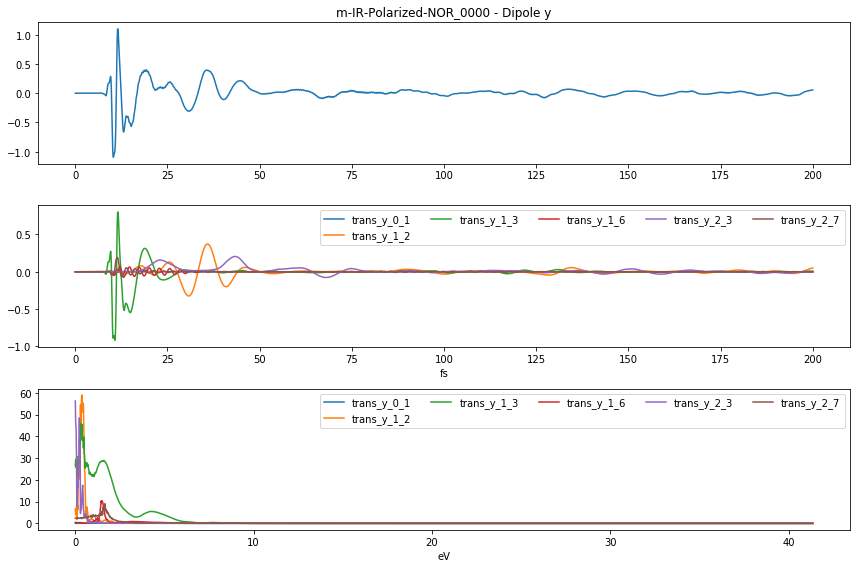

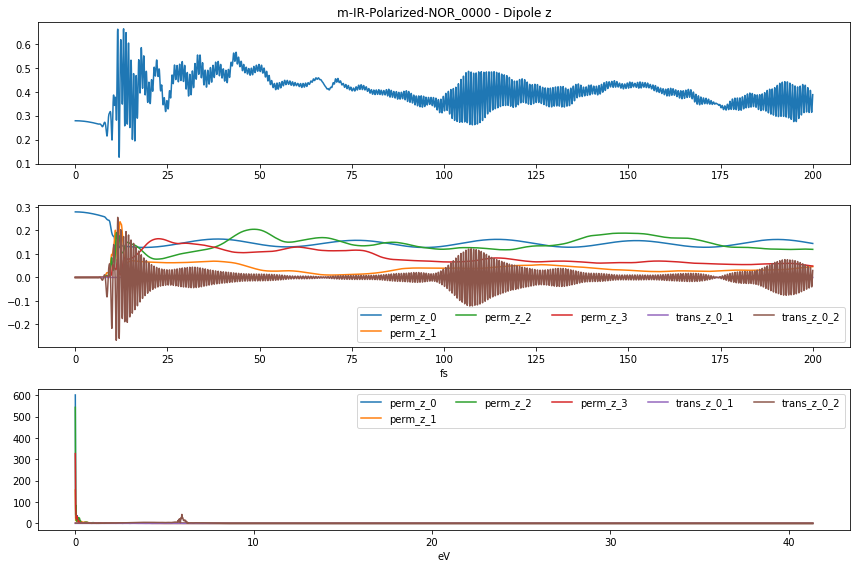

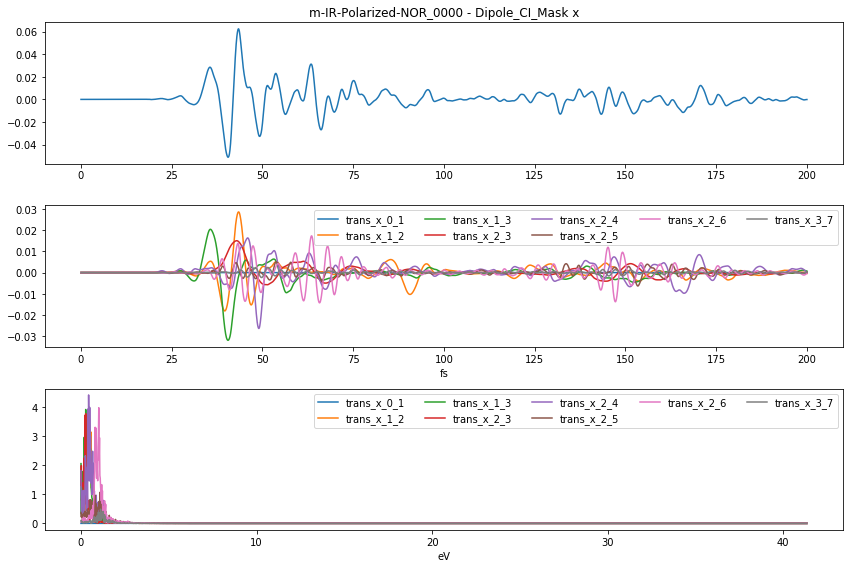

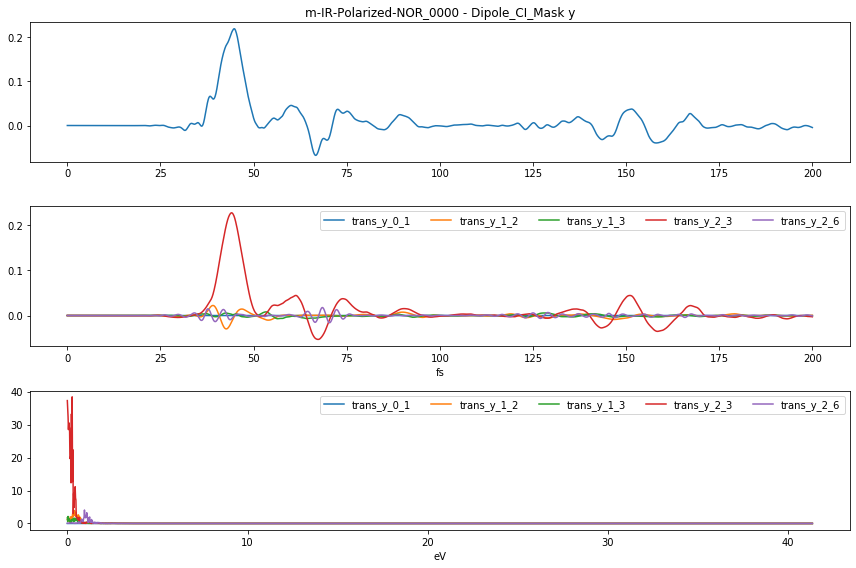

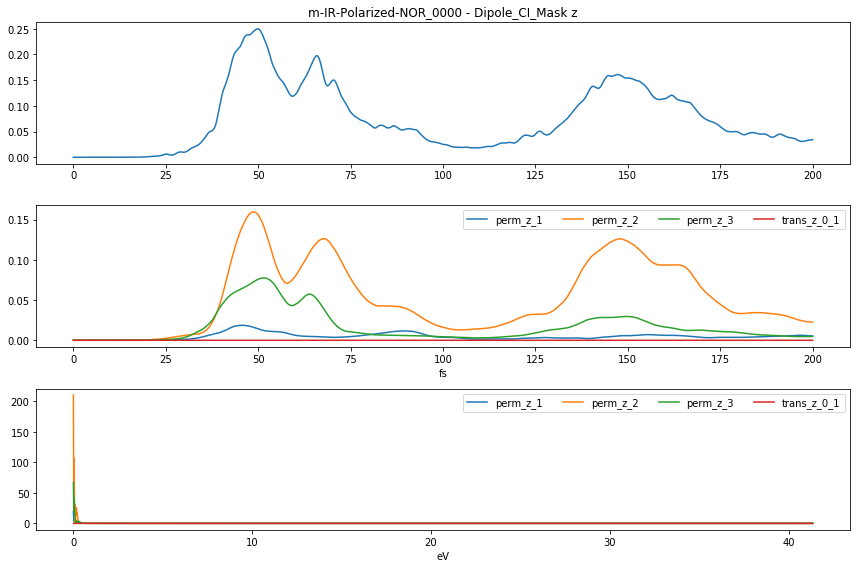

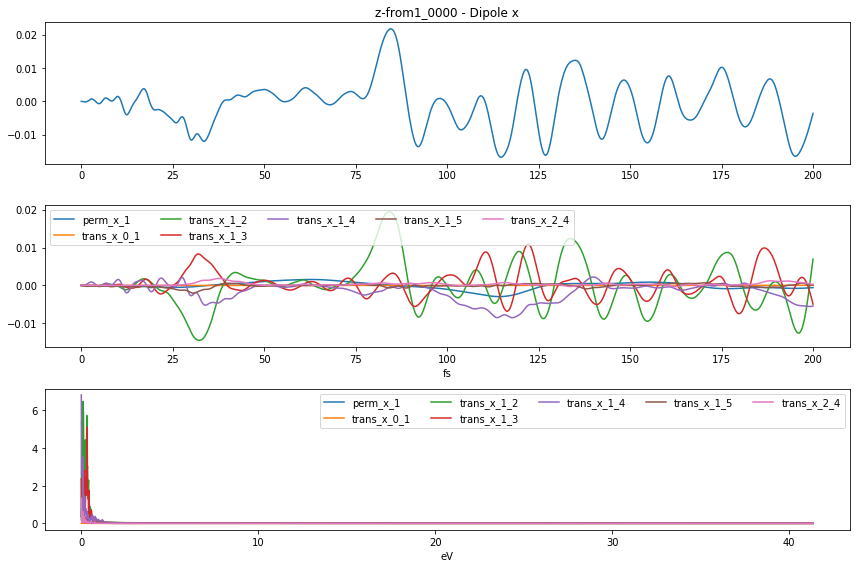

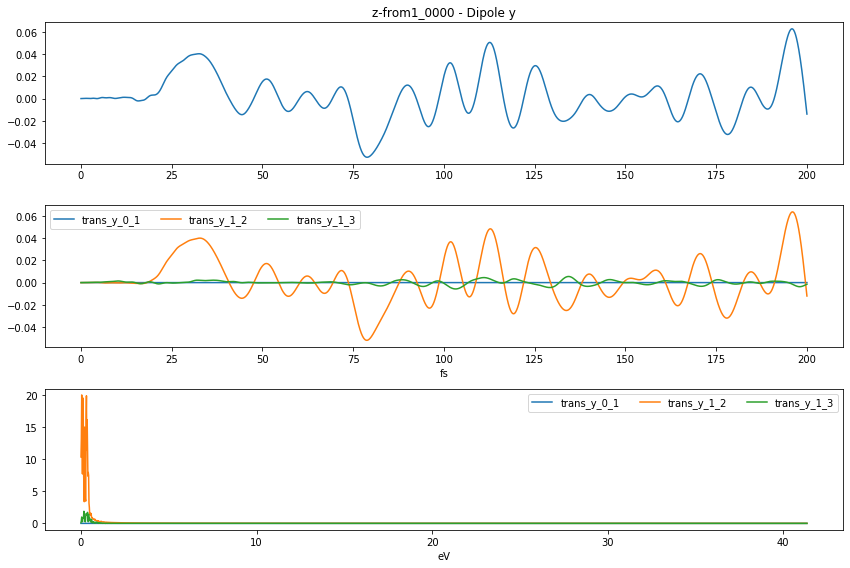

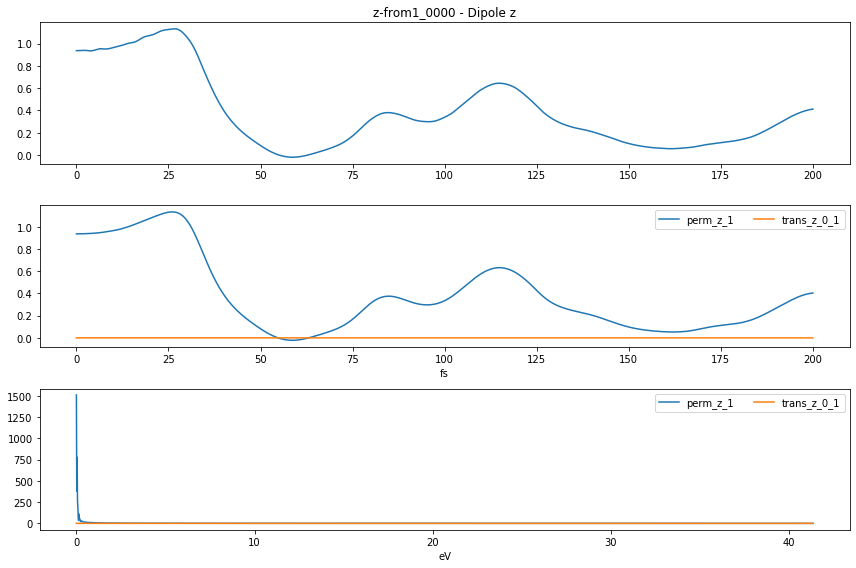

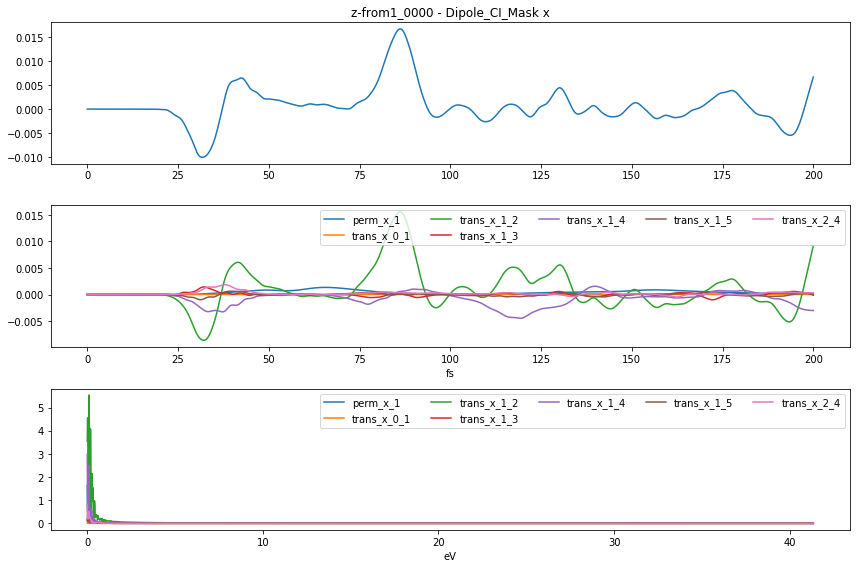

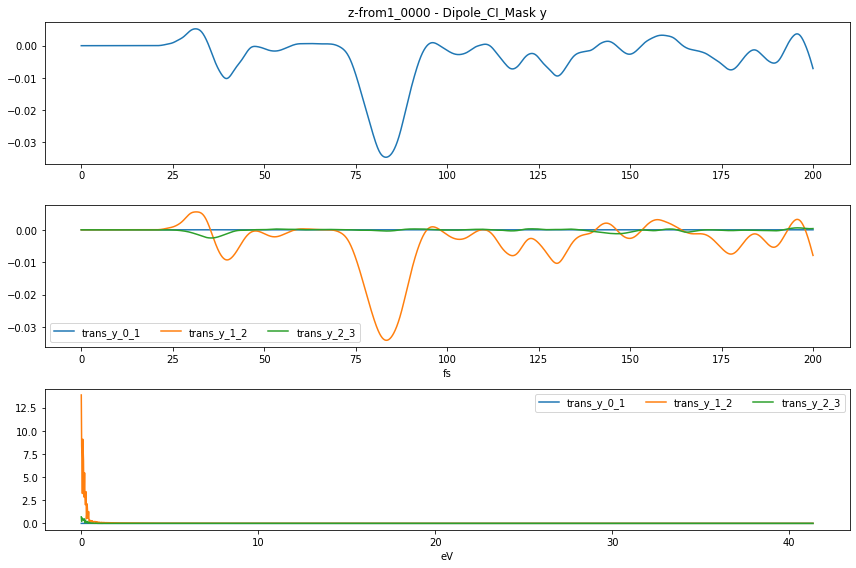

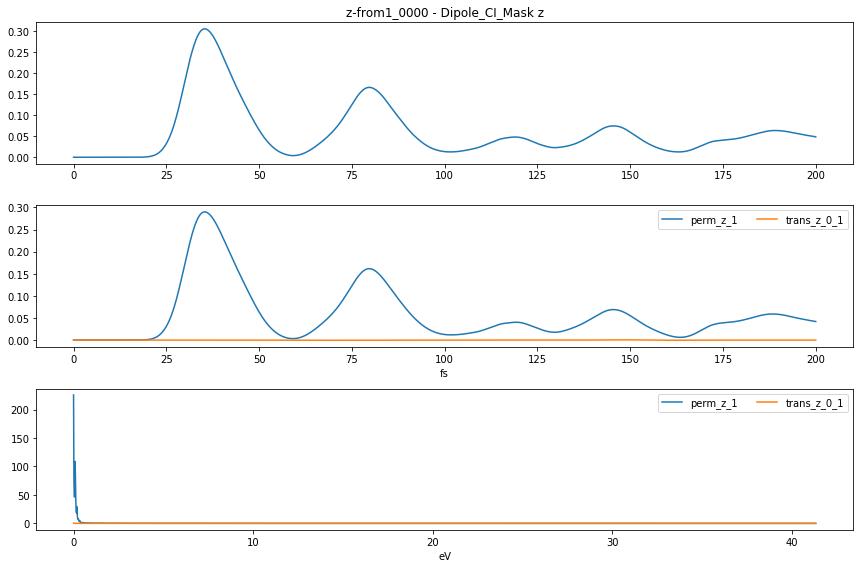

In [5]:
plt.close('all')

def reorder_dataframe_last_first(df):
    '''used to reorder dataframe'''
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    return df[cols]

def process_folder(this_folder,fol,outputFolder):
    project_folder = os.path.join(fol,this_folder)
    for mask_or_not in ['','_CI_Mask']:
        subname = 'Output_Dipole{}'.format(mask_or_not)
        output_dipo = os.path.join(project_folder, subname)
        all_labels = ['fs_2','dipx','dipy','dipz'] +  permanents + transitions
        df_dipo2 = pd.read_csv(output_dipo, delim_whitespace=True, names=all_labels)

        fran_df_dipole = pd.DataFrame()
        fran_df_freq = pd.DataFrame()

        for cart in ['x','y','z']:
            full_list_label = permanents + transitions
            full_list_this_cart = [x for x in full_list_label if cart in x]

            # setting figure
            fig, [ax0,ax1,ax2] = plt.subplots(3,1,figsize = (12,8))

            # first panel is just total signal
            timefs = df_dipo2['fs_2']
            time = qp.fromFsToAu(timefs)
            this_full_dipole = 'dip{}'.format(cart)
            tot_signal = df_dipo2[this_full_dipole]
            ax0.plot(timefs,tot_signal)
            
            dt = time[1]-time[0]
            t = time
            x = df_dipo2[this_full_dipole]

            fft_array, freq = fft_artisanal(np.array(t),np.array(x))
            
            # I record the full dft for signal in x,y or z
            fran_df_freq['DFT-{}{}'.format(this_full_dipole,mask_or_not)] = np.abs(fft_array)

            #second panel is big components
            threshold = np.linalg.norm(tot_signal)*0.05 # 5% of the norm
            big_components = [ x for x in full_list_this_cart if np.linalg.norm(df_dipo2[x]) > threshold or x in ['trans_x_0_1', 'trans_y_0_1', 'trans_z_0_1'] ] # the one which contributes more than 5% to the norm
            print(big_components)

            fran_df_dipole[this_full_dipole] = df_dipo2[this_full_dipole]

            for this_lab in big_components:
                ax1.plot(timefs, df_dipo2[this_lab], label=this_lab)



        # THIS PART FOR DFT
                dt = time[1]-time[0]

                t = time
                x = df_dipo2[this_lab]

                fft_array, freq = fft_artisanal(np.array(t),np.array(x))
    #             print(fft_array.shape, freq.shape)

                ev_freq = qp.fromHartoEv(freq)
                abs_fft_array = np.abs(fft_array)
                ax2.plot(ev_freq, abs_fft_array, label=this_lab)

                # add the things into Francoise df
    #             print(df_dipo2[this_lab].shape,fft_array.shape)
                fran_df_dipole['{}{}'.format(this_lab,mask_or_not)] = df_dipo2[this_lab]
                fran_df_freq['DFT-{}{}'.format(this_lab,mask_or_not)] = abs_fft_array



        # #  THOSE LINES TO DEBUG WITH GNUPLOT
        # #     degub_fodler = '/home/alessio/Desktop/'

        # #     np.savetxt(os.path.join(degub_fodler,'file1'),a)
        # #     np.savetxt(os.path.join(degub_fodler,'file2'),b)


            ax1.legend(ncol=5)
            ax1.set_xlabel('fs')
            ax2.legend(ncol=5)
            ax2.set_xlabel('eV')
            ax0.set_title('{} - Dipole{} {}'.format(this_folder,mask_or_not,cart))
            fig.tight_layout()

        # this needs to be ONCE in the df of Francoise
        fran_df_dipole['time fs'] = timefs
        fran_df_freq['DFT-Frequencies eV'] = ev_freq
        fran_df_dipole = reorder_dataframe_last_first(fran_df_dipole)
        fran_df_freq = reorder_dataframe_last_first(fran_df_freq)

        fran_df_dipole.to_csv(os.path.join(outputFolder,'{}_dipoles{}.csv'.format(this_folder,mask_or_not)))
        fran_df_freq.to_csv(os.path.join(outputFolder,'{}_dipoles_DFT{}.csv'.format(this_folder,mask_or_not)))

    
process_folder(subfolders[0],fol,outputFolder)    
process_folder(subfolders[1],fol,outputFolder)
process_folder(subfolders[2],fol,outputFolder)
process_folder(subfolders[3],fol,outputFolder)
process_folder(subfolders[16],fol,outputFolder)

# Try to clean signal part

In [6]:
# def adjust_signal(sig,ext):
#     sig_size = sig.size
#     array_value = np.zeros(ext)
#     sig_array = np.array(dipz)
#     flipped = np.flip(sig_array,axis=0)
    
#     output_signal = np.concatenate((array_value,flipped,sig_array,array_value))
#     return(output_signal)

# def adjust_time(time,full_length):
#     time_size = time.size
#     time_final_value = time[time_size-1]
#     total_time = np.linspace(-time_final_value,time_final_value,full_length)
#     return(total_time)
    


# sig_ext = adjust_signal(dipz,1000)
# time_ext = adjust_time(time,10002)

In [7]:
file1 = '/home/alessio/w-August-Run/OUTPUTS/b-UV-0.22_0000_dipoles.csv'
file2 = '/home/alessio/w-August-Run/OUTPUTS/b-UV-0.22_0000_dipoles_DFT.csv'
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
print(df1.keys(), df2.keys())
signal_time = df1['time fs']
signal = df1['dipx']

ff_freq = df2['DFT-Frequencies eV']
ff_signal = df2['DFT-dipx']

Index(['Unnamed: 0', 'time fs', 'dipx', 'trans_x_0_1', 'trans_x_1_2',
       'trans_x_1_3', 'trans_x_1_4', 'dipy', 'trans_y_0_1', 'trans_y_1_2',
       'trans_y_1_3', 'trans_y_1_4', 'trans_y_1_5', 'trans_y_2_3',
       'trans_y_6_7', 'dipz', 'perm_z_0', 'perm_z_1', 'trans_z_0_1',
       'trans_z_1_4'],
      dtype='object') Index(['Unnamed: 0', 'DFT-Frequencies eV', 'DFT-dipx', 'DFT-trans_x_0_1',
       'DFT-trans_x_1_2', 'DFT-trans_x_1_3', 'DFT-trans_x_1_4', 'DFT-dipy',
       'DFT-trans_y_0_1', 'DFT-trans_y_1_2', 'DFT-trans_y_1_3',
       'DFT-trans_y_1_4', 'DFT-trans_y_1_5', 'DFT-trans_y_2_3',
       'DFT-trans_y_6_7', 'DFT-dipz', 'DFT-perm_z_0', 'DFT-perm_z_1',
       'DFT-trans_z_0_1', 'DFT-trans_z_1_4'],
      dtype='object')


(0, 10)

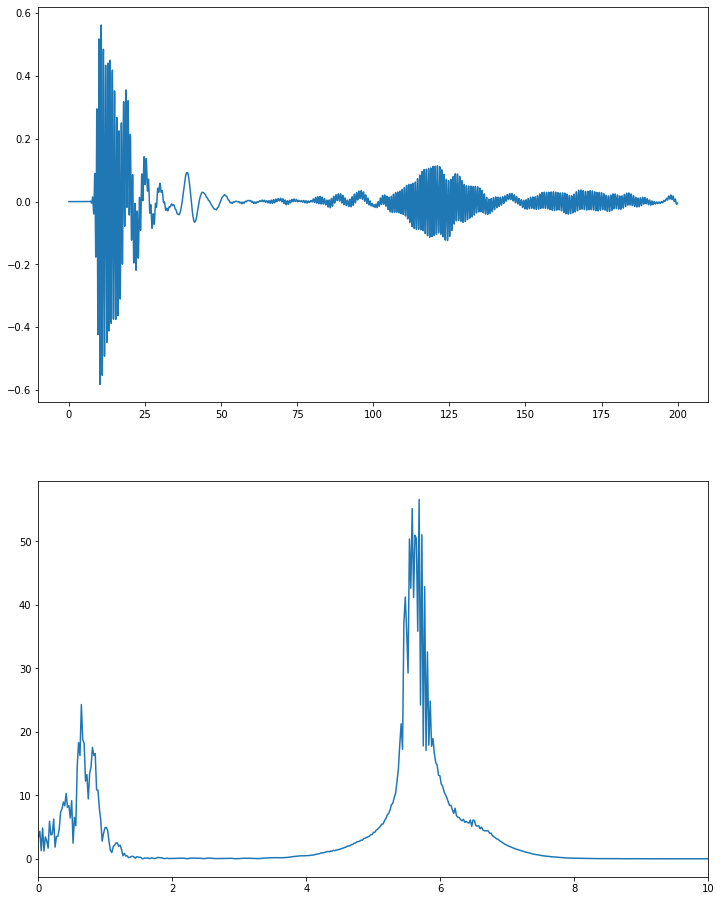

In [8]:
fig, [ax0,ax1] = plt.subplots(2,1,figsize = (12,16))
ax0.plot(signal_time,signal)
ax1.plot(ff_freq,ff_signal)
ax1.set_xlim(0,10)

(2001,) (2001,)
(4001,) (4001,)


(0, 10)

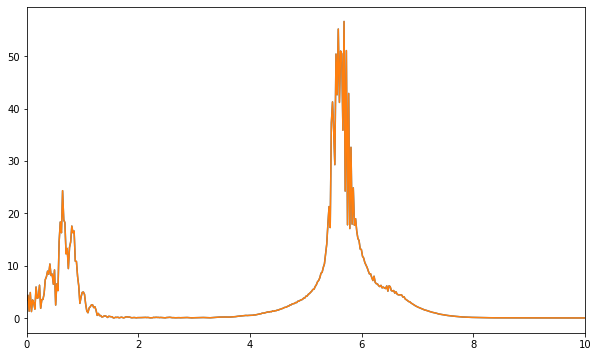

In [9]:
def pythonfft(signal_time,signal):
    aaa = abs(np.fft.fft(signal))
    time_au = qp.fromFsToAu(signal_time)
    dt = time_au[1]- time_au[0]
    bb = np.fft.fftfreq(time_au.size)

    time_au_max = np.amax(time_au)
    bbb = qp.fromHartoEv(bb*2*np.pi/dt)
    indexes = np.where(bb>=0)
    return(bbb[indexes],aaa[indexes])

#print(np.amax(bbb), np.amax(ff_freq), np.amax(ff_freq)/np.amax(bbb))

bbb,aaa = pythonfft(signal_time,signal)
print(bbb.shape,aaa.shape)
print(signal.shape, signal_time.shape)
fig, ax0 = plt.subplots(1,1,figsize = (10,6))

ax0.plot(bbb,aaa)
ax0.plot(ff_freq,ff_signal)
ax0.set_xlim(0,10)

In [10]:
file1 = '/home/alessio/w-August-Run/OUTPUTS/b-UV-0.22_0000_dipoles_DFT.csv'
file2 = '/home/alessio/w-August-Run/OUTPUTS/b-UV-0.22_0000_dipoles_DFT_CI_Mask.csv'
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
print(df1.keys(),df2.keys())

Index(['Unnamed: 0', 'DFT-Frequencies eV', 'DFT-dipx', 'DFT-trans_x_0_1',
       'DFT-trans_x_1_2', 'DFT-trans_x_1_3', 'DFT-trans_x_1_4', 'DFT-dipy',
       'DFT-trans_y_0_1', 'DFT-trans_y_1_2', 'DFT-trans_y_1_3',
       'DFT-trans_y_1_4', 'DFT-trans_y_1_5', 'DFT-trans_y_2_3',
       'DFT-trans_y_6_7', 'DFT-dipz', 'DFT-perm_z_0', 'DFT-perm_z_1',
       'DFT-trans_z_0_1', 'DFT-trans_z_1_4'],
      dtype='object') Index(['Unnamed: 0', 'DFT-Frequencies eV', 'DFT-dipx_CI_Mask',
       'DFT-perm_x_1_CI_Mask', 'DFT-trans_x_0_1_CI_Mask',
       'DFT-trans_x_1_2_CI_Mask', 'DFT-trans_x_1_3_CI_Mask',
       'DFT-trans_x_1_4_CI_Mask', 'DFT-trans_x_1_5_CI_Mask',
       'DFT-trans_x_2_4_CI_Mask', 'DFT-trans_x_2_5_CI_Mask',
       'DFT-dipy_CI_Mask', 'DFT-trans_y_0_1_CI_Mask',
       'DFT-trans_y_1_2_CI_Mask', 'DFT-trans_y_1_3_CI_Mask',
       'DFT-trans_y_1_4_CI_Mask', 'DFT-trans_y_1_5_CI_Mask',
       'DFT-trans_y_2_3_CI_Mask', 'DFT-trans_y_2_4_CI_Mask',
       'DFT-dipz_CI_Mask', 'DFT-perm_z_1_CI

(0, 10)

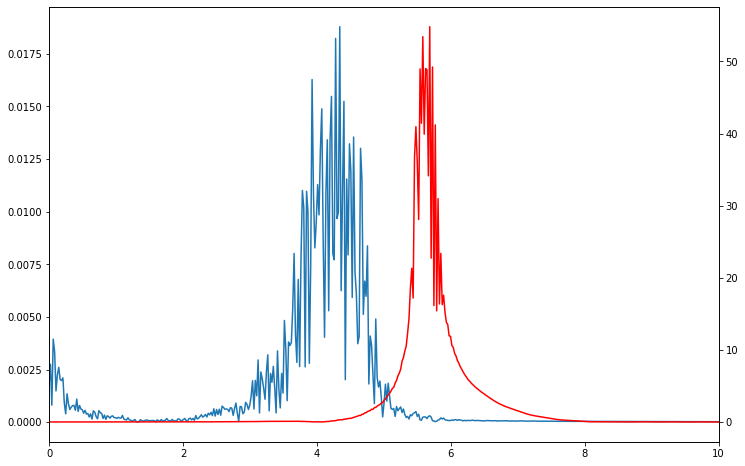

In [11]:
fig, ax0 = plt.subplots(1,1,figsize = (12,8))
ax0.plot(df2['DFT-Frequencies eV'],df2['DFT-trans_x_0_1_CI_Mask'])
ax1 = ax0.twinx()
ax1.plot(df1['DFT-Frequencies eV'],df1['DFT-trans_x_0_1'],color='r')
ax0.set_xlim(0,10)
ax1.set_xlim(0,10)